# Agentic AI - Chart Generation

## 1. Introduction

This notebook implements the **reflection pattern** within an agentic workflow that generates data visualizations. A multi-modal LLM will review the first draft chart, identify potential improvements—such as chart type, labels, or color choices—and then rewrite the chart generation code to produce a more effective visualization.

The steps that the workflow will carry out are:

1. **Generate an initial version (V1):**
Use a Large Language Model (LLM) to create the first version of the plotting code.

2. **Execute code and create chart:** 
Run the generated code and display the resulting chart.

3. **Reflect on the output:**
Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).

4. **Generate and execute improved version (V2):**
Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

## 2. Setup: Initialize environment and client

In this step, you import the key libraries that will support the workflow:  

- **`plotly`** - This is used to load the gapminder dataset that will be used to create the chart.
- **`re`**: Python’s regular expression module, which you’ll use to extract snippets of code or structured text from the LLM’s output.  
- **`json`**: Provides functions to read and write JSON, useful for handling structured responses returned by the LLM.  
- **`utils`**: A custom helper module provided for this lab. It includes utility functions to work with the dataset, generate charts, and display results in a clean, readable format.  


In [1]:
# Standard library imports
import sys
sys.path.append("../../agentic-ai")
import plotly.express as px
import json
from typing import Dict, Any
import re
import json

# Local helper module
from utils import utils

In [2]:
# Use this utils.py function to load the data into a dataframe
df = utils.load_and_prepare_gapminder()

# Grab a random sample to display
utils.print_html(df.sample(n=5), title="Gapminder Preview")

country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
Mozambique,Africa,1982,42.795,12587223,462.211415,MOZ,508
Djibouti,Africa,1982,48.812,305991,2879.468067,DJI,262
Zimbabwe,Africa,1962,52.358,4277736,527.272182,ZWE,716
"Congo, Dem. Rep.",Africa,1977,47.804,26480870,795.757282,COD,180
South Africa,Africa,1997,60.236,42835005,7479.188244,ZAF,710


We will building the agentic ai pipeline that generates data visualizations from this dataset

## 3. Building the pipeline

### 3.1 Generate Code to Create a Chart (V1)

In this step, you’ll prompt an LLM to write Python code that generates a chart in response to a user query about the gapminder dataset. The dataset includes fields such as `country`, `continent`, `lifeExp`, and `gdpPercap`, and you will pass this schema into the LLM so it knows what data is available.  

The question you’ll ask the model to create a scatter plot of GDP per capita and life expectancy in log scale using the data from 2007 onwards for all the continents. The detailed instruction is outlined in the below cell.

The LLM’s output will be Python code using the **matplotlib** library. Instead of displaying the chart directly, the code will be written between `<execute_python>` tags so it can be extracted and run in later steps. You’ll learn more about these tags in Module 3.  


In [3]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - country: object
    - continent: object
    - year: int64
    - lifeExp: float64
    - pop: int64
    - gdpPercap: float64

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

Now, let's try out the function and analyze the response!

In [4]:
instruction = """
Create a scatter plot where:
- X-axis is GDP per capita (log scale)
- Y-axis is life expectancy
- Points are colored by continent
- Use data from the year 2007
- Include a clear title and axis labels
"""

chart_code = generate_chart_code(
    instruction=instruction,
    model="gpt-4o-mini", 
    out_path_v1="chart_v1.png"
)

utils.print_html(chart_code, title="Generated Chart Code")

Notice that the code is wrapped between `<execute_python>` tags. These tags make it easy to automatically extract and run the code in the next step of the workflow.  

### 3.2. Execute Code and Create Chart

In this step, a regular expression is used to extract the Python code that the LLM generated in the previous step (the part written between `<execute_python>` tags). Once extracted, you’ll run this code to produce the **first draft chart**.  

Here's how it works:

1. **Extract the code:**  
   A regex pattern is used to grab the code that’s wrapped inside the `<execute_python>` tags.

2. **Execute the code:**
   The extracted code is run in a predefined global context where the DataFrame `df` is already available. This means your code can directly use df without needing to reload the dataset.

3. **Generate the chart::**
   If the code executes successfully, it will create a chart and save it as `chart_v1.png`.

4. **View the chart in the notebook:**
   The saved chart is then displayed inline using `utils.print_html`, making it easy to review the results.


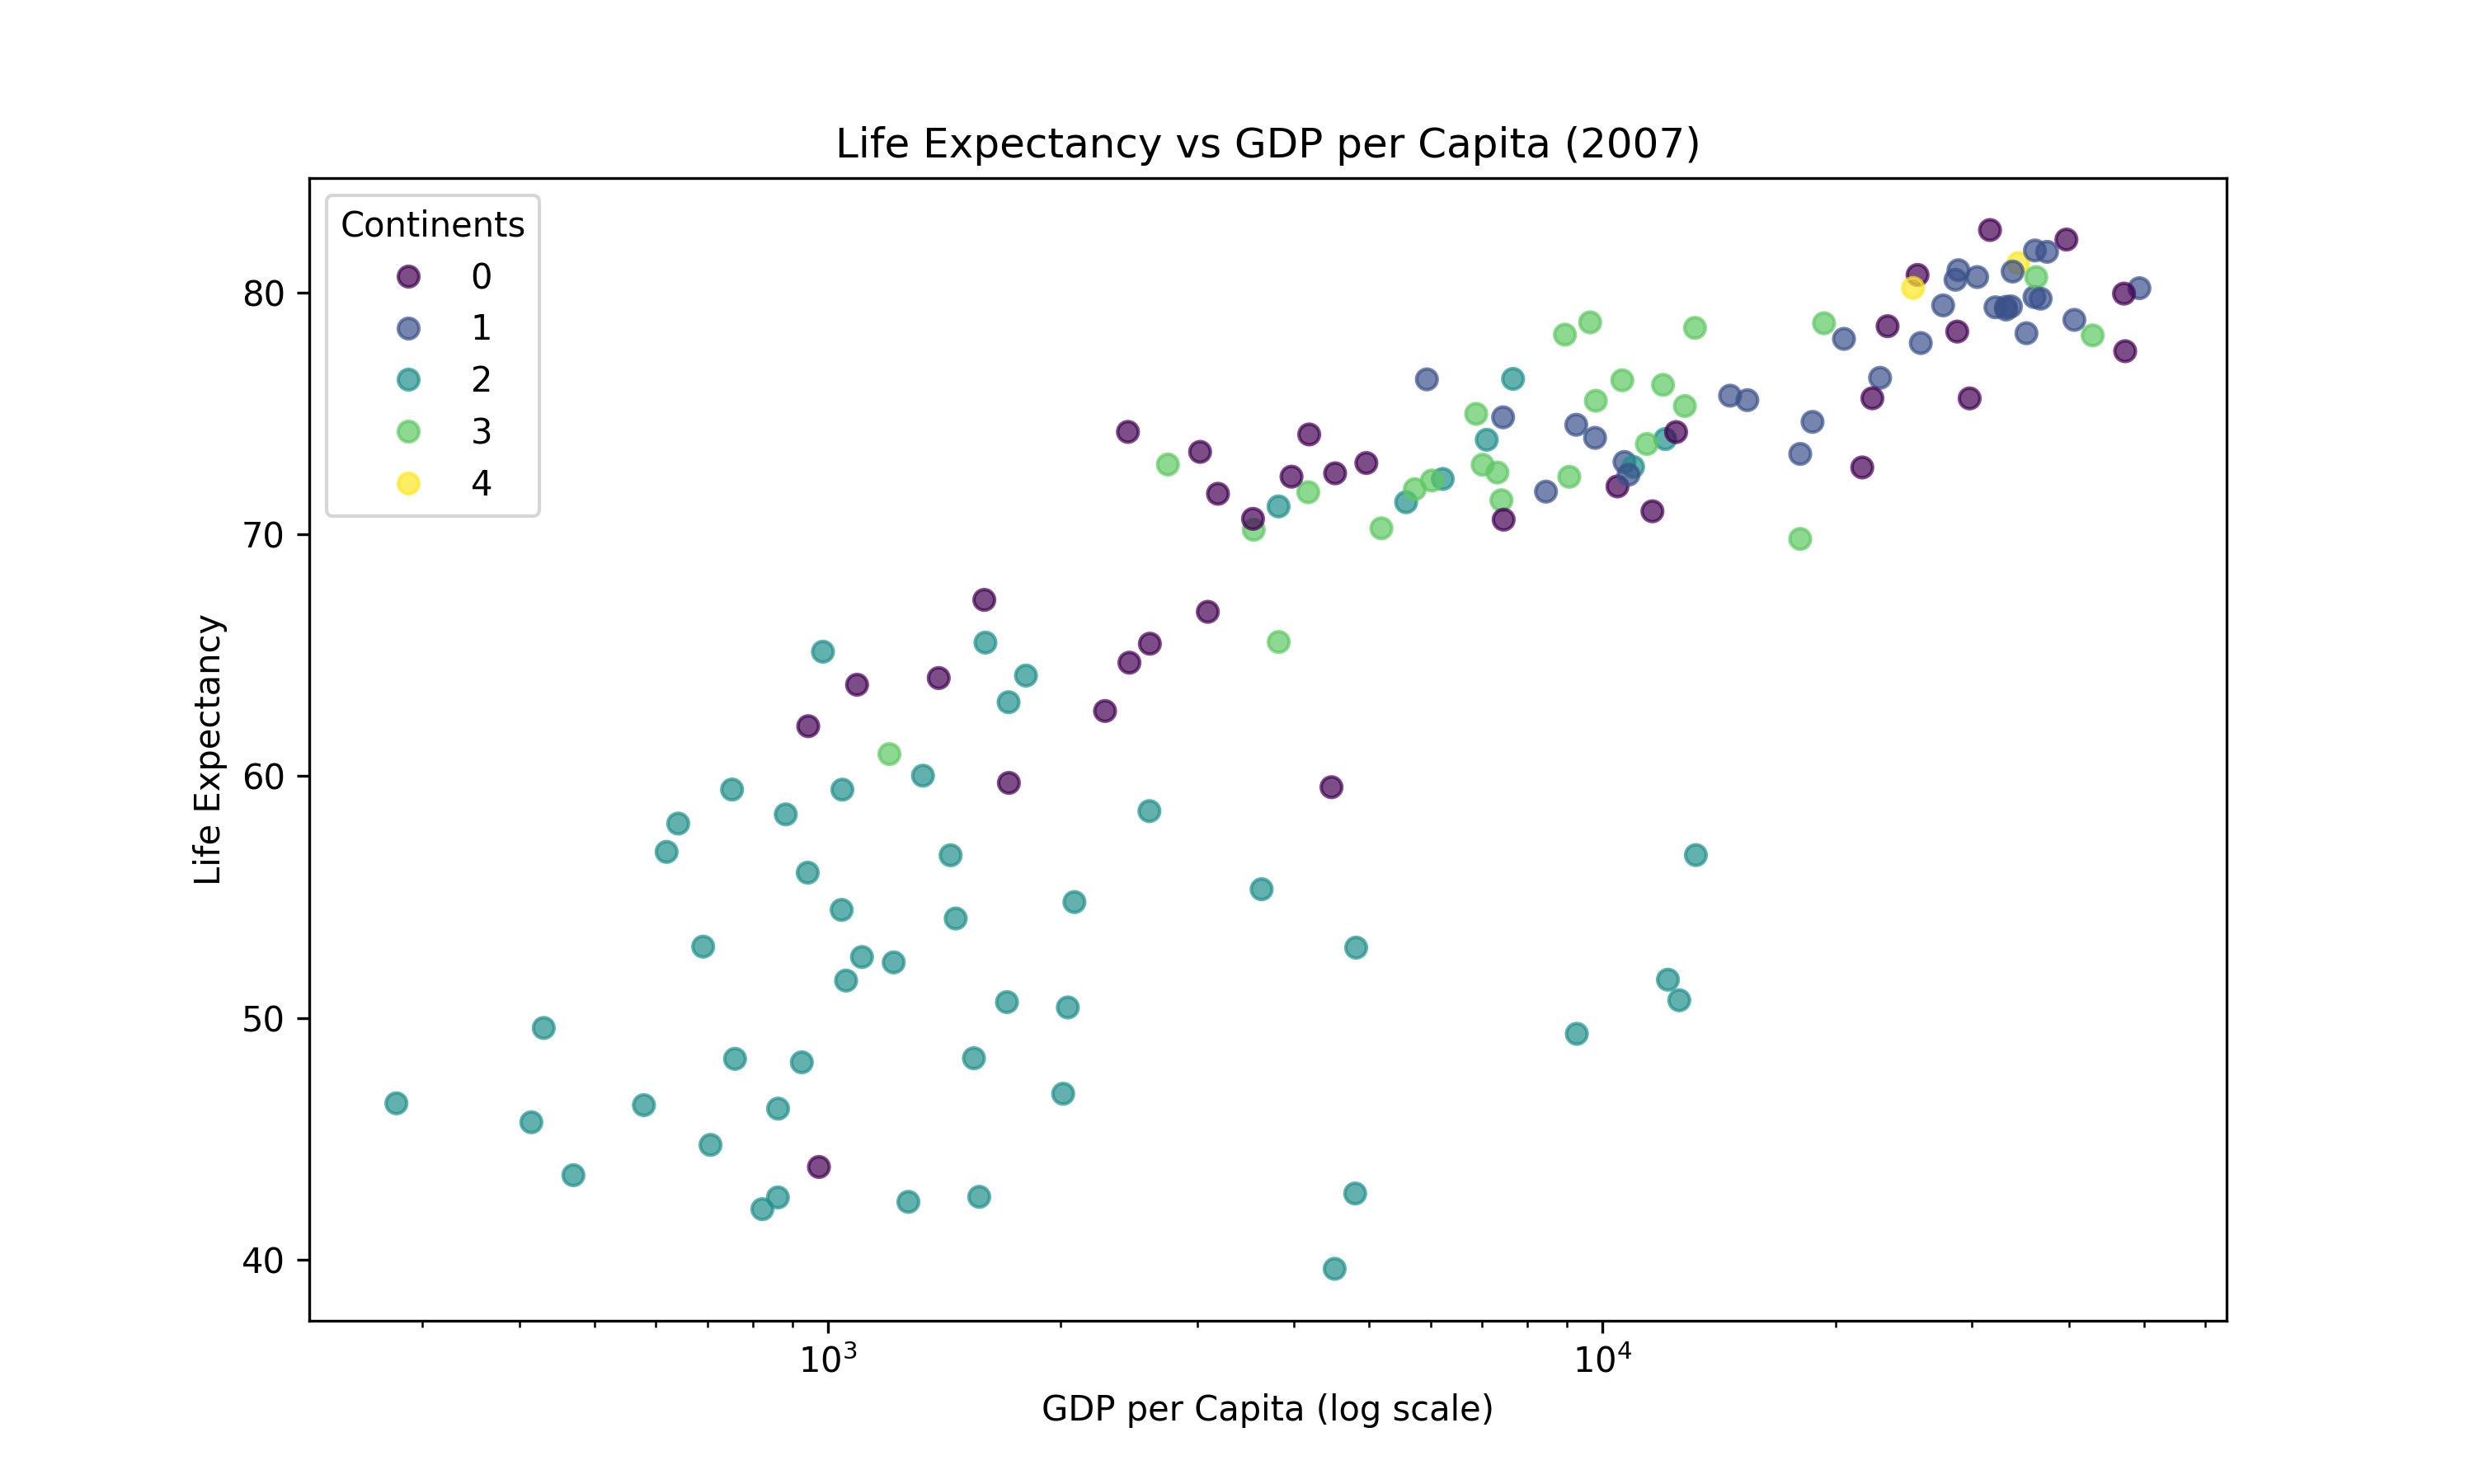

In [5]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", chart_code)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

### 3.3. Reflect on the output

The goal here is to simulate how a human would review a first draft of a chart—looking for strengths, weaknesses, and areas for improvement.

Here’s what happens:

**1. Provide the chart to the LLM:**
The generated chart (chart_v1.png) is shared with the LLM so it can “see” the visualization.

**2. Analyze the chart visually:**
The LLM reviews elements like clarity, labeling, accuracy, and overall readability.

**3. Generate feedback:**
The LLM suggests improvements—for example, fixing axis labels, adjusting the chart type, improving color choices, or highlighting missing legends.

By doing this, we create an intelligent feedback loop where the chart is not just produced once, but actively critiqued—setting the stage for a stronger second version (V2).

In [6]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)
    

    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - country: object
    - continent: object
    - year: int64
    - lifeExp: float64
    - pop: int64
    - gdpPercap: float64

    Instruction:
    {instruction}
    """


    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code



Note that, the model is instructed to return its response in **JSON format**.  

- JSON is a lightweight, structured format (key–value pairs) that makes it easy to parse the LLM’s output programmatically.  
- Here, we require two fields:  
  - **`feedback`**: a short critique of the current chart.  
  - **`refined_code`**: an improved Python code snippet wrapped in `<execute_python>` tags.  

We also include a **“constraints” section** in the prompt. These rules (e.g., use matplotlib only, save the file to a specific path, call `plt.close()` at the end) help the model generate consistent, runnable code that fits the workflow. Without these constraints, the output might vary too much or include unwanted formatting.  


### 3.4 Generate and Execute Improved Version (V2)

In this final step, it’s time to generate and run the improved version of the chart (V2).  
After running the cell, we notice that **both the reflection written by the LLM** (explaining what needed improvement) **and the new code it generated**. The new code will then be executed to produce the updated chart.  

In [7]:
# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction=instruction, 
    model_name="o4-mini",
    out_path_v2="chart_v2.png",
    code_v1=chart_code,   # pass in the original code for context        
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")

Now let's execute the refined code returned by the reflection step.  The code inside the `<execute_python>` tags is extracted, run against the dataset, and used to generate the updated chart.  

If the execution is successful, you’ll see the new image (`chart_v2.png`) displayed below as the **Regenerated Chart (V2)**.  


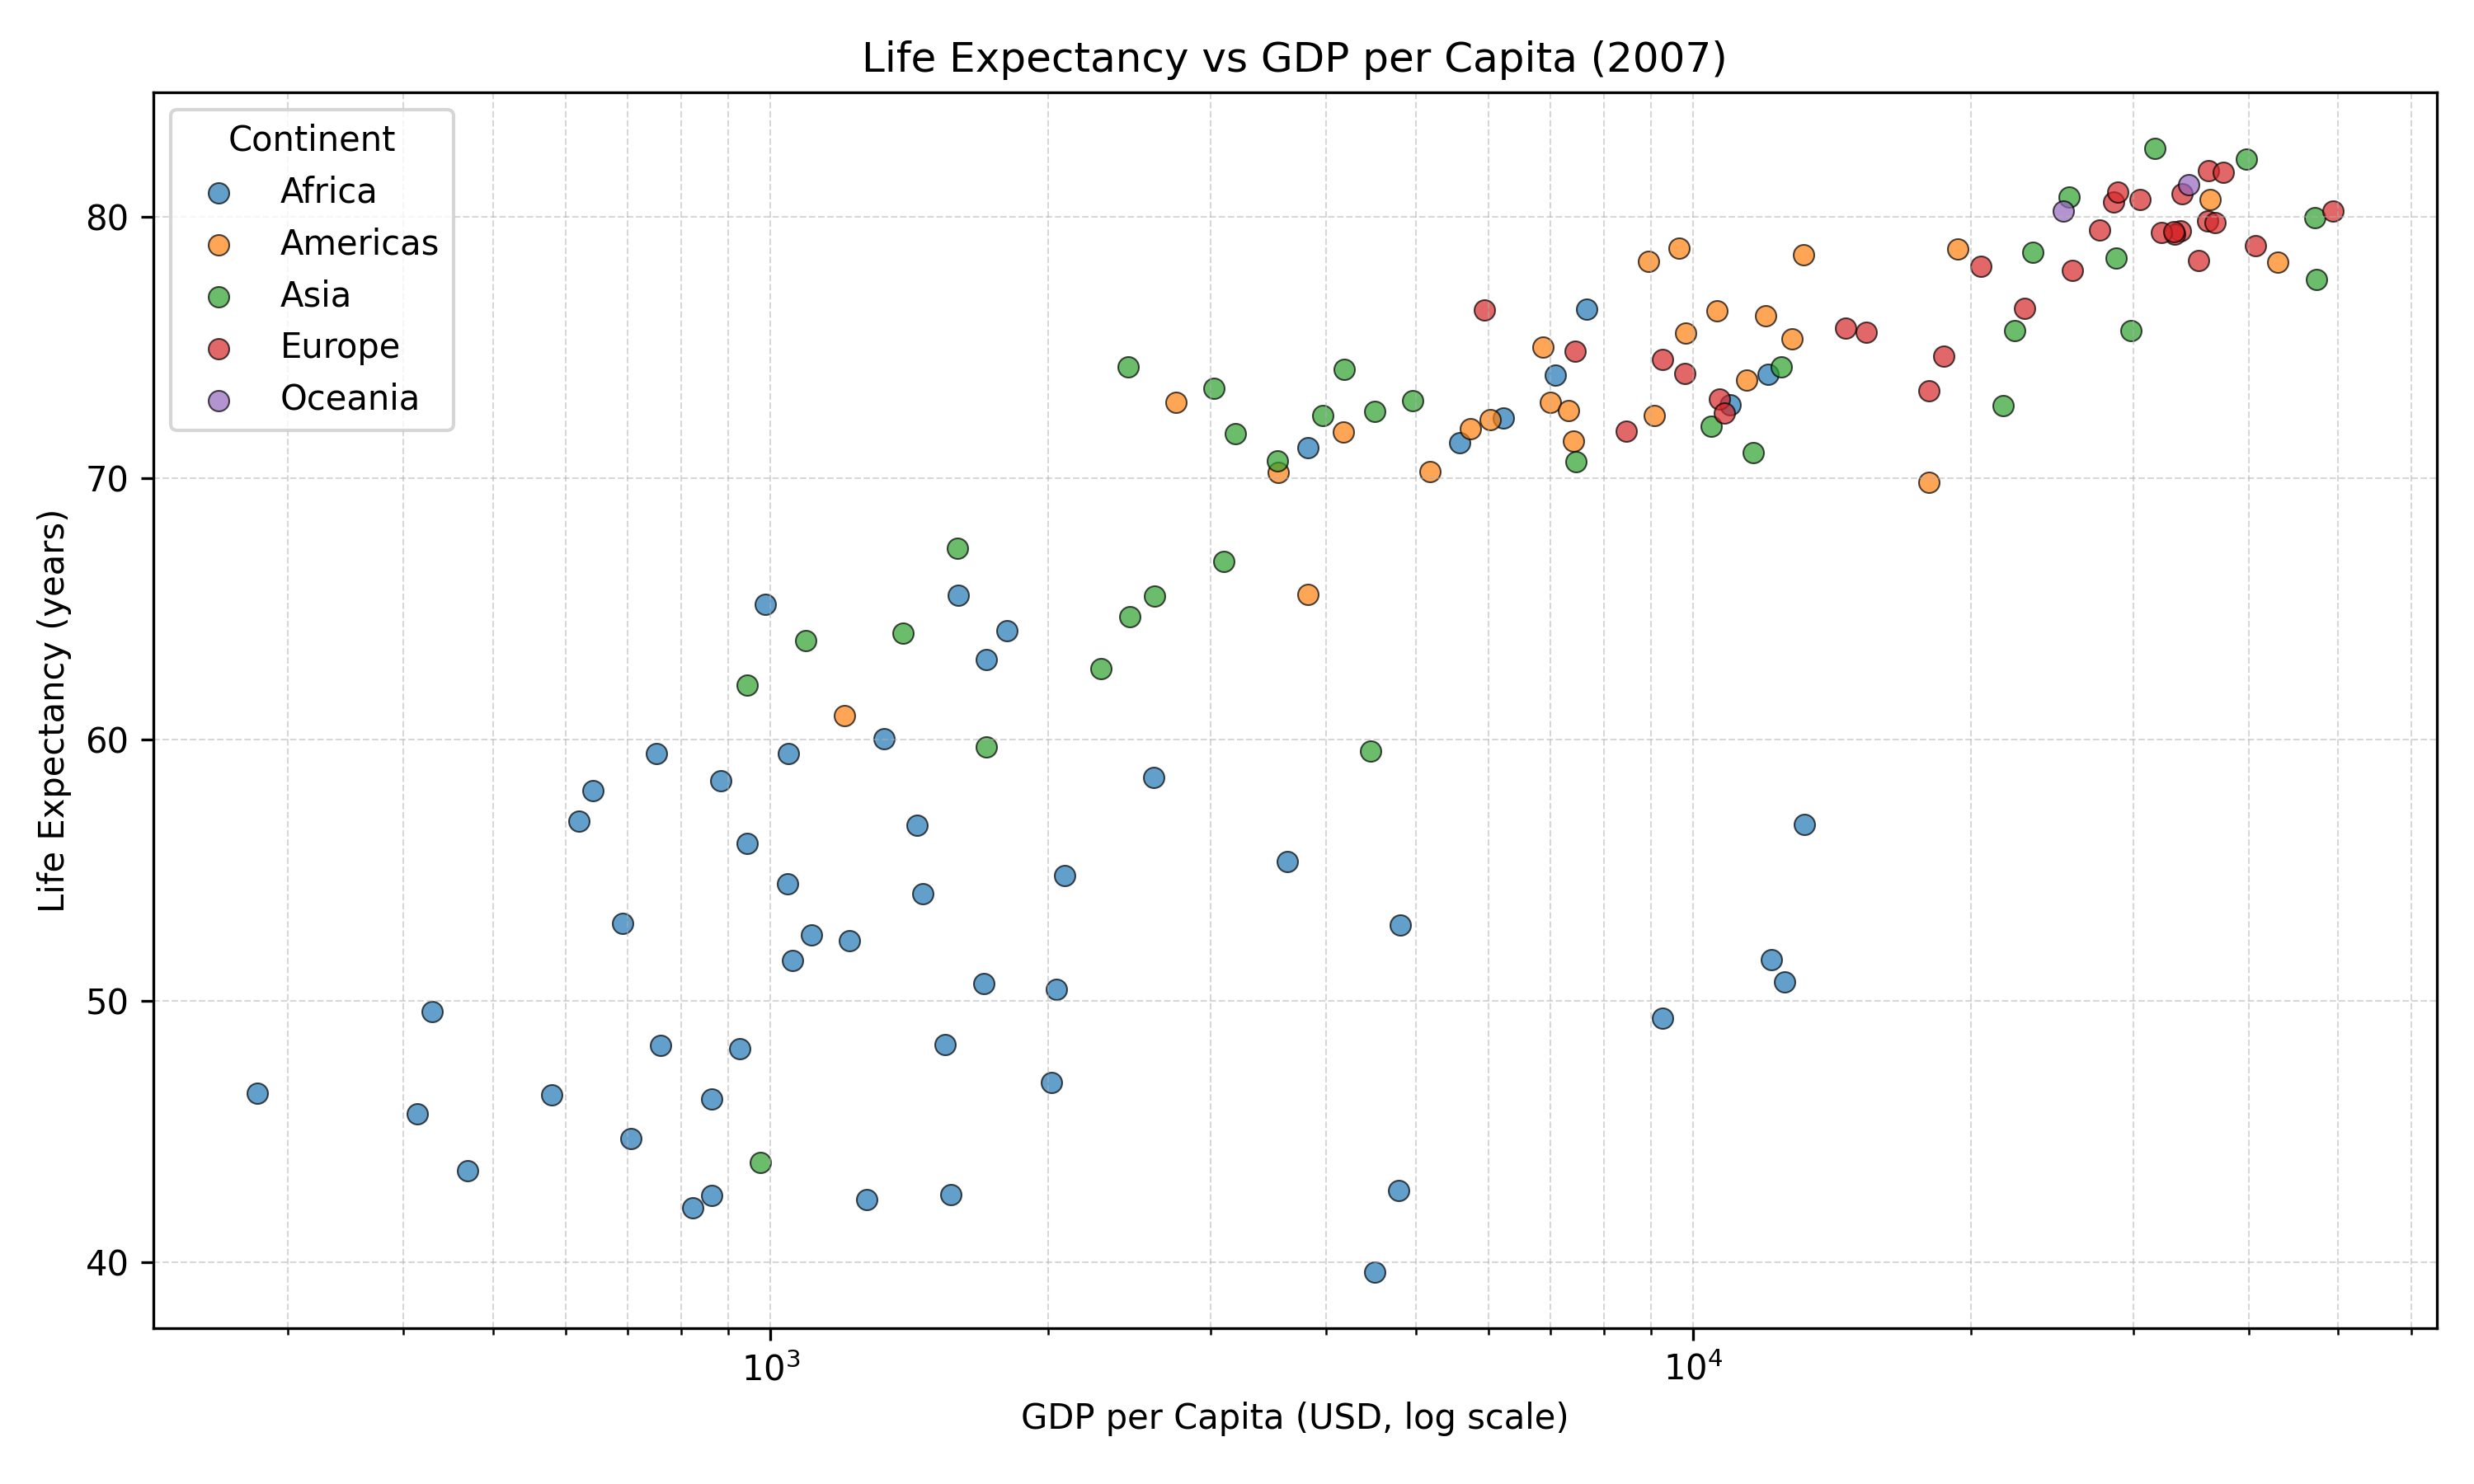

In [8]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

## 4. Final Takeaways

In this notebook, we practiced using reflection to improve chart outputs.
Specifically, following items were covered:

* Generate an initial chart (V1).
* Critique and refine it into a better version (V2).
* Automate the full workflow with different models.

The key idea: reflection helps to create clearer, more accurate, and more effective visualizations.
